In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyscf
from pyscf import gto,dft,scf

In [3]:
# import neuralxc
# from neuralxc.projector.pyscf import get_eri3c as get_mlovlp
import torch
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from dpyscf.net import * 
from dpyscf.torch_routines import * 
from dpyscf.utils import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/sebastian/miniconda3/envs/e3nn/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'eig']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
torch.set_default_dtype(torch.double)

In [ ]:
torch.cuda.current_device()
torch.cuda.is_available()
torch.cuda.get_device_name(0)
torch.set_default_dtype(torch.double)

In [5]:
DEVICE='cpu'

In [130]:
level = 'GGA'
xc = 'x'
ref = 'GGA_X_PBE'

In [131]:
n_hidden =16
if level == 'GGA':
    if xc == 'x':
        local = XC_L(device=DEVICE,n_input=1, n_hidden=n_hidden, spin_scaling=True, use=[1], lob=True)
    elif xc == 'c':
        local = C_L(device=DEVICE,n_input=3, n_hidden=n_hidden, use=[2])
elif level == 'MGGA':
    if xc == 'x':
        local = XC_L(device=DEVICE, n_input=2, n_hidden=n_hidden, spin_scaling=True, use=[1, 2], lob=True)
    elif xc == 'c':
        local = C_L(device=DEVICE, n_input=4, n_hidden=n_hidden, use=[2,3])
        
ueg = LDA_X()
xc = XC(grid_models=[local], heg_mult=True, level= {'GGA':2, 'MGGA':3}[level])
xc.epsilon = 0
# if xc == 'c':
xc.loge = 1e-8
#     xc.s_gam = 0.01

In [132]:
local.load_state_dict(torch.load('../models/pretrained/pbe/x',map_location=torch.device('cpu')))

<All keys matched successfully>

In [110]:
def get_mol(atoms, basis='6-311++G**'):
    pos = atoms.positions
    spec = atoms.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.M(atom=mol_input, basis=atoms.info.get('basis',basis),spin=atoms.info.get('spin',0))
    except Exception:
        mol = gto.M(atom=mol_input, basis=atoms.info.get('basis','STO-3G'),spin=atoms.info.get('spin',0))
    return mol 

In [111]:
def get_rhos(rho, spin):
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    if spin != 0:
        rho0_a = rho0[0]
        rho0_b = rho0[1]
        gamma_a, gamma_b = torch.einsum('ij,ij->j',drho[:,0],drho[:,0]), torch.einsum('ij,ij->j',drho[:,1],drho[:,1])              
        gamma_ab = torch.einsum('ij,ij->j',drho[:,0],drho[:,1])
        tau_a, tau_b = tau
    else:
        rho0_a = rho0_b = rho0*0.5
        gamma_a=gamma_b=gamma_ab= torch.einsum('ij,ij->j',drho[:],drho[:])*0.25
        tau_a = tau_b = tau*0.5
    return rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b

In [112]:
def get_data_synth(xc_func, n=100):
    def get_rho(s, a):
        c0 = 2*(3*np.pi**2)**(1/3)
        c1 = 3/10*(3*np.pi**2)**(2/3)
        gamma = c0*s
        tau = c1*a+c0**2*s**2/8
        rho = np.zeros([len(a),6])
        rho[:, 1] = gamma
        rho[:,-1] = tau
        rho[:, 0] = 1
        return rho
    
    s_grid = np.concatenate([[0],np.exp(np.linspace(-10,4,n))])
#     a_grid =[1000]
    rho = []
    for s in s_grid:
        if 'MGGA' in xc_func:
            a_grid = np.concatenate([np.exp(np.linspace(np.log((s/100)+1e-8),8,n))])
        else:
            a_grid = np.array([0])
        rho.append(get_rho(s, a_grid))
        
    rho = np.concatenate(rho)
    
    fxc =  dft.numint.libxc.eval_xc(xc_func,rho.T, spin=0)[0]/dft.numint.libxc.eval_xc('LDA_X',rho.T, spin=0)[0] -1
 
    rho = torch.from_numpy(rho)
    
    tdrho = xc.get_descriptors(rho[:,0]/2,rho[:,0]/2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,rho[:,5]/2,rho[:,5]/2, spin_scaling=True)
    


    tFxc = torch.from_numpy(fxc)
    return tdrho[0], tFxc

In [113]:
def get_data(mol, xc_func ,full=False, enhance_spin=False):
    mf = scf.UKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 1
    mf.kernel()
    coords, weights = half_circle(35, 25)
    if not full:
        mf.grids.coords = coords
        mf.grids.weights = weights
    if local.spin_scaling:
        rho_alpha = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[1], xctype='metaGGA',hermi=True)
        fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_alpha,rho_alpha*0), spin=1)[0] -1
        fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_beta*0,rho_beta), spin=1)[0] -1
        if mol.spin != 0 and sum(mol.nelec)>1:
            rho = np.concatenate([rho_alpha, rho_beta])
            fxc = np.concatenate([fxc_a, fxc_b])
        else:
            rho = rho_alpha
            fxc = fxc_a
    else:    
        rho_alpha = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[1], xctype='metaGGA',hermi=True)
        exc = mf._numint.eval_xc(xc_func,(rho_alpha,rho_beta), spin=1)[0]
#         fxc = exc/mf._numint.eval_xc('LDA_X',(rho_alpha, rho_beta), spin=1)[0] -1
        fxc = exc
        rho = np.stack([rho_alpha,rho_beta], axis=-1)
    
    dm = torch.from_numpy(mf.make_rdm1())
    ao_eval = torch.from_numpy(mf._numint.eval_ao(mol, mf.grids.coords, deriv=1))
    rho = torch.einsum('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)
    
    if dm.ndim == 3:
        rho_filt = (torch.sum(rho[0,0],dim=0) > 1e-6)
    else:
        rho_filt = (rho[0,0] > 1e-6)
    tdrho = xc.get_descriptors(*get_rhos(rho, spin=1), spin_scaling=local.spin_scaling)
    
#     tdrho = torch.from_numpy(tdrho.detach().numpy().round(8))
        
    if local.spin_scaling:
        if mol.spin != 0 and sum(mol.nelec) > 1:
            tdrho = torch.cat([tdrho[0],tdrho[1]])
            rho_filt = torch.cat([rho_filt]*2)
            
        else:
            tdrho = tdrho[0]
    tdrho = tdrho[rho_filt]

    tFxc = torch.from_numpy(fxc)[rho_filt]
#     tFxc = torch.from_snumpy(fxc)
    return tdrho, tFxc

In [114]:
spins = {
    'Al': 1,
    'B' : 1,
    'Li': 1,
    'Na': 1,
    'Si': 2 ,
    'Be':0,
    'C': 2,
    'Cl': 1,
    'F': 1,
    'H': 1,
    'N': 3,
    'O': 2,
    'P': 3,
    'S': 2
}

selection = [2, 113, 25, 18, 11, 17, 114, 121, 101, 0, 20, 26, 29, 67, 28, 110, 125, 10, 115, 89, 105, 50]
atoms = [read('../data/haunschild_g2/g2_97.traj',':')[s] for s in selection]
ksr_atoms = atoms
if level=='MGGA':
    ksr_atoms = ksr_atoms[2:]
ksr_atoms = [Atoms('H', info={'spin':1}),Atoms('Li', info={'spin':1}), Atoms('O',info={'spin':2}),Atoms('Cl',info={'spin':1}),Atoms('Al',info={'spin':1}),Atoms('S',info={'spin':2})] + ksr_atoms
# ksr_atoms = [Atoms('H',info={'spin':1})]
mols = [get_mol(atoms) for atoms in ksr_atoms]

In [118]:
# data = [get_data(mol, xc_func=ref, full=i<12) for i,mol in enumerate(mols)]
data = [get_data(mol, xc_func=ref,full=False) for i,mol in enumerate(mols)]
# 
data += [get_data_synth(ref, 500)]
tdrho = torch.cat([d[0] for d in data]).to(DEVICE)
tFxc = torch.cat([d[1] for d in data]).to(DEVICE)

converged SCF energy = -0.499812985362865  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -7.46006188627841  <S^2> = 0.75000049  2S+1 = 2.0000005
converged SCF energy = -75.0033804479684  <S^2> = 2.0027444  2S+1 = 3.0018291


<ipython-input-113-f5d8a9a7fa77>:14: RuntimeWarning: invalid value encountered in true_divide
  fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_beta*0,rho_beta), spin=1)[0] -1


converged SCF energy = -459.957577119854  <S^2> = 0.7516194  2S+1 = 2.0016187
converged SCF energy = -242.226560999673  <S^2> = 0.75226413  2S+1 = 2.0022629
converged SCF energy = -397.938786815494  <S^2> = 2.0022329  2S+1 = 3.0014882
converged SCF energy = -1.16580491182897  <S^2> = 1.3322676e-15  2S+1 = 1
converged SCF energy = -109.439263799566  <S^2> = 1.0658141e-14  2S+1 = 1
converged SCF energy = -107.339357395544  <S^2> = 4.2632564e-14  2S+1 = 1
converged SCF energy = -93.3377924464758  <S^2> = 5.2828941e-10  2S+1 = 1
converged SCF energy = -188.456965322797  <S^2> = 3.8582471e-12  2S+1 = 1
converged SCF energy = -920.005608888994  <S^2> = 4.938272e-13  2S+1 = 1
converged SCF energy = -199.394370591257  <S^2> = 1.1191048e-13  2S+1 = 1
converged SCF energy = -150.21489453132  <S^2> = 1.0018599  2S+1 = 2.2377309
converged SCF energy = -77.243504834649  <S^2> = 1.1546319e-14  2S+1 = 1
converged SCF energy = -113.221335689615  <S^2> = 2.8421709e-14  2S+1 = 1
converged SCF energy = -

In [119]:
# nan_filt = ~torch.any((tdrho != tdrho),dim=-1)

# tFxc = tFxc[nan_filt]
# tdrho = tdrho[nan_filt,:]

In [121]:
PRINT_EVERY=200
optimizer = torch.optim.Adam(local.parameters(),
                         lr=0.0001,weight_decay=0)

eloss = torch.nn.MSELoss()


for epoch in range(100000):
    total_loss = 0
    results = local(tdrho[::])
    loss = eloss(results, tFxc[::])
    total_loss += loss.item()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    if epoch%PRINT_EVERY==0:
        print('total loss {:.12f}'.format(total_loss))
        


total loss 0.000000004839
total loss 0.000000003477
total loss 0.000000003473
total loss 0.000000003468
total loss 0.000000003463
total loss 0.000000003457
total loss 0.000000003451
total loss 0.000000003445
total loss 0.000000003439
total loss 0.000000003433
total loss 0.000000003427
total loss 0.000000003422


KeyboardInterrupt: 

In [122]:
drho = tdrho[:,-1].cpu().detach()

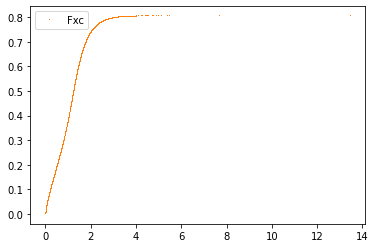

In [123]:
plot(drho, local(tdrho).cpu().detach().data,ls ='',marker=',')
plot(drho, tFxc.cpu(),ls='',marker=',',label='Fxc')
legend()
# xlim(0,3)
# xscale('log')
# yscale('log')

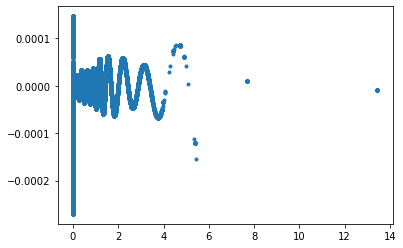

In [124]:
plot(drho, (local(tdrho).cpu()-tFxc.cpu()).detach().data,ls='',marker='.')
# plot(np.exp(drho), Fxc.detach().data)
# xscale('log')

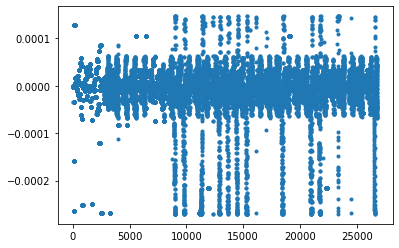

In [125]:
plot((local(tdrho).cpu()-tFxc.cpu()).detach().data,ls='',marker='.')

In [126]:
# torch.save(local.state_dict(), '../models/pretrained/pbe')

In [127]:
loc = '../models/pretrained/GGA_X_PBE_ML2'

In [128]:
xc.evaluate()
xc.epsilon=1e-7

In [129]:
xc.forward = xc.eval_grid_models
traced = torch.jit.trace(xc, torch.abs(torch.rand(100,9)))
try:
    os.mkdir(loc)
except:
    pass
torch.jit.save(traced, loc +'/xc')

/home/sebastian/Research/NEURALXC/dpyscf/dpyscf/net.py:433: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(self.use) > 1:
/home/sebastian/Research/NEURALXC/dpyscf/dpyscf/net.py:324: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.all(rho0_b == torch.zeros_like(rho0_b)): #Otherwise produces NaN's
